## Nitrogen recovery technology suitability calculator: User sample code

### Multi-criteria suitability index for prioritizing early stage deployments of wastewater derived fertilizers in sub-Saharan Africa

Corisa Wong, Meagan Mauter, David Lobell

Sept 2023


### About:
- N suitability calculator code uses baseline equal weighting scheme as described in the paper. 
- Dictionary of weights can be modified based on desired user preference.
- Users can append additional datasets and modify parameters within the calculator based on their analysis needs.

### Data:
- Input data:
    - Admin2 level (district) level data on population, sanitation, fertilizer price/profitability, soil characteristics, potential N recovery/people fed from N recovery in sub-Saharan Africa
        - Districts missing data were excluded from the analysis
        - See paper for dataset details, assumptions, and computations.

- Output: 
    - Total suitability index values and parameter specific indices added to the input dataset.
    - District level map of resulting suitability scores.
    - Country level distribution of suitability scores.
    - Note that subsequent processing is needed for contiguous regional analyses as this is district level.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
pd.options.display.max_rows = 20

In [2]:
# Load input dataset and apply geometries
df = pd.read_csv('Nrecovery_compiled_dataset_user_example.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
df_full = gpd.GeoDataFrame(df, crs='epsg:4326')

In [3]:
# Define dictionary for weights: Standard weighting scheme (can adjust)

wt_bds_dict = {
    'pop_weight': 0.25,
    'san_weight':  0.25,
    'soil_weight': 0.25,
    'financial_weight':0.25,
    
    'soilph_weight':0.5,
    'soilcec_weight':0.25,
    'soilclay_weight':0.25,
    
    'fertprice_weight':0.25,
    'profit_weight':0.25,
    'econyield_weight':0.5,
    
    'population': {'min_popdensity': 300 ,
                   'min_totpop': 5000,
                   'units': 'people and people/km2'},
    'sanitation': {'min_san': 3, 'max_san': 5},
    'soil': {'lwbd_ph': 4.5, 'upbd_ph': 5.5 ,
             'lwbd_cec': 4 ,'upbd_cec':10 , 
             'lwbd_clay':7, 'upbd_clay':15},
    'financial': {'lwbd_Nfertprice': 1, 'upbd_Nfertprice': 2 ,
                  'lwbd_profit': 1 ,'upbd_profit':100 , 
                  'lwbd_econyield':1, 'upbd_econyield':1000,
                  'units':'$USD/kg N as urea, $USD/kg N, kg maize/ha'},
}

In [4]:
def compute_suit(wt_bds_dict, df_full):
    '''
    
    Computes suitability indices based on weights and bounds of interest using input dataframe
    
    Major weights should sum to 1 (san_weight, pop_weight, soil_weight, financial_weight)
    Minor weights should sum to 1 in their respective sub-categories 
    
    Arguments: 
        wt_bds_dict: Dictionary with bounds and weightings of interest.
        df_full: Input dataset
    
    Returns:
        Calculated suitability index values for all observations
    
    '''
    
    # extract parameters
    
    san_weight = wt_bds_dict['san_weight']
    pop_weight = wt_bds_dict['pop_weight']
    soil_weight = wt_bds_dict['soil_weight']
    financial_weight = wt_bds_dict['financial_weight']
    
    ph_weight = wt_bds_dict['soilph_weight']
    cec_weight = wt_bds_dict['soilcec_weight']
    clay_weight = wt_bds_dict['soilclay_weight']
    
    fertprice_weight = wt_bds_dict['fertprice_weight']
    econyield_weight = wt_bds_dict['econyield_weight']
    profit_weight = wt_bds_dict['profit_weight']
    
    min_san, max_san = wt_bds_dict['sanitation']['min_san'], wt_bds_dict['sanitation']['max_san']

    min_popdensity = wt_bds_dict['population']['min_popdensity']
    min_totpop = wt_bds_dict['population']['min_totpop']
    
    lwbd_ph, upbd_ph = wt_bds_dict['soil']['lwbd_ph'], wt_bds_dict['soil']['upbd_ph']
    lwbd_cec, upbd_cec = wt_bds_dict['soil']['lwbd_cec'], wt_bds_dict['soil']['upbd_cec']
    lwbd_clay, upbd_clay = wt_bds_dict['soil']['lwbd_clay'], wt_bds_dict['soil']['upbd_clay']

    lwbd_Nfertprice = wt_bds_dict['financial']['lwbd_Nfertprice']
    upbd_Nfertprice = wt_bds_dict['financial']['upbd_Nfertprice']
    
    lwbd_profit = wt_bds_dict['financial']['lwbd_profit']
    upbd_profit = wt_bds_dict['financial']['upbd_profit']
    lwbd_econyield = wt_bds_dict['financial']['lwbd_econyield']
    upbd_econyield = wt_bds_dict['financial']['upbd_econyield']
    
    # RAISE ERROR IF NOT SUM TO 1 (allows for small rounding margin of error)

    sum_major_wts = san_weight + pop_weight + soil_weight + financial_weight
    if np.abs(sum_major_wts - 1) > 0.001:
        raise ValueError("Major weights must sum to 1")
        
    sum_minor_soilwts = ph_weight + cec_weight + clay_weight 
    if (sum_minor_soilwts - 1) > 0.001:
        raise ValueError("Minor soil weights (pH, cec, clay) must sum to 1")
        
    sum_minor_finwts = fertprice_weight + econyield_weight + profit_weight
    if (sum_minor_finwts - 1) > 0.001:
        raise ValueError("Minor financial weights (price, profit, yield) must sum to 1")
    
    
    # Compute Suitability:
    # Fully suitable if value is above upper bound
    # Values in between upper and lower bound will be linearly interpolated

    san_param = np.where(((df_full['mean_san_index'] >= min_san) 
                      & (df_full['mean_san_index'] <= max_san)),1,0)

    pop_param = np.where(((df_full['max_pop_den'] >= min_popdensity) 
                      & (df_full['tot_pop'] >= min_totpop)),1,0)

    col         = 'avg_ph'
    conditions  = [ df_full[col] >= upbd_ph,
                   (df_full[col] < upbd_ph) & (df_full[col]> lwbd_ph),
                   df_full[col] <= lwbd_ph ]
    choices     = [ 1, (df_full[col] - lwbd_ph)/(upbd_ph-lwbd_ph), 0 ]
    param3_ph = np.select(conditions, choices, default=np.nan)

    col         = 'avg_cec'
    conditions  = [ df_full[col] >= upbd_cec,
                   (df_full[col] < upbd_cec) & (df_full[col]> lwbd_cec),
                   df_full[col] <= lwbd_cec ]
    choices     = [ 1, (df_full[col] - lwbd_cec)/(upbd_cec-lwbd_cec), 0 ]
    param3_cec = np.select(conditions, choices, default=np.nan)

    col         = 'avg_claycontent'
    conditions  = [ df_full[col] >= upbd_clay,
                   (df_full[col] < upbd_clay) & (df_full[col]> lwbd_clay),
                   df_full[col] <= lwbd_clay]
    choices     = [ 1, (df_full[col] - lwbd_clay)/(upbd_clay-lwbd_clay), 0 ]
    param3_clay = np.select(conditions, choices, default=np.nan)

    col         = 'mean_Nfert_price'
    conditions  = [ df_full[col] >= upbd_Nfertprice,
                   (df_full[col] < upbd_Nfertprice) & (df_full[col]> lwbd_Nfertprice),
                   df_full[col] <= lwbd_Nfertprice]
    choices     = [ 1, (df_full[col] - lwbd_Nfertprice)/(upbd_Nfertprice-lwbd_Nfertprice), 0 ]
    param4_Nfertprice = np.select(conditions, choices, default=np.nan)


    col         = 'maxfertprofit_avg_bonced'
    conditions  = [ df_full[col] >= upbd_profit , 
                   (df_full[col] < upbd_profit) & (df_full[col]> lwbd_profit),
                   df_full[col] <= lwbd_profit]
    choices     = [ 1, (df_full[col] - lwbd_profit)/(upbd_profit-lwbd_profit), 0 ]
    param4_profit_avg = np.select(conditions, choices, default=np.nan)

    col         = 'econyieldgap_avg_bonced'
    conditions  = [ df_full[col] >= upbd_econyield, 
                   (df_full[col] < upbd_econyield) & (df_full[col]> lwbd_econyield),
                   df_full[col] <= lwbd_econyield]
    choices     = [ 1, (df_full[col] - lwbd_econyield)/(upbd_econyield-lwbd_econyield), 0 ]
    param4_econyield_avg = np.select(conditions, choices, default=np.nan)

    zero_bounded = np.where(((df_full['maxfertprofit_emp_bonced'] == 0) 
                      | (df_full['maxfertprofit_mech_bonced'] == 0)
                      | (df_full['econyieldgap_emp_bonced'] == 0)
                      | (df_full['econyieldgap_mech_bonced'] == 0)
                      ),0,1) # anywhere any of these are 0, set area to not financially suitable i.e. set to 0

    # Compute full suitability scores

    df_suit = pd.DataFrame(
        san_param * san_weight
        + pop_param * pop_weight
        + soil_weight * (
            ph_weight * param3_ph
            + cec_weight * param3_cec
            + clay_weight * param3_clay
        )
        + financial_weight * zero_bounded * (
            fertprice_weight * param4_Nfertprice
            + profit_weight * param4_profit_avg
            + econyield_weight * param4_econyield_avg
        )
    )

    df_suit.columns = ['suitability']

    # round up 0.999 to 1 to account for slight rounding errors
    df_suit['suitability'] = np.where(df_suit['suitability'] > 0.999, 1, df_suit['suitability'] ) 

    df_suit_join = df_full.join(df_suit)

    # Compute categorical suitability scores
    df_suit_san = pd.DataFrame(san_param)
    df_suit_san.columns = ['suitability_san']
    df_suit_join2 = df_suit_join.join(df_suit_san)

    df_suit_pop = pd.DataFrame(pop_param)
    df_suit_pop.columns = ['suitability_pop']
    df_suit_join3 = df_suit_join2.join(df_suit_pop)

    df_suit_soil = pd.DataFrame(
         (ph_weight * param3_ph
            + (cec_weight * param3_cec + clay_weight * param3_clay)
        )
    )

    df_suit_soil.columns = ['suitability_soil']
    df_suit_join4 = df_suit_join3.join(df_suit_soil)

    df_suit_financial = pd.DataFrame(
        zero_bounded * (
            (fertprice_weight * param4_Nfertprice + profit_weight * param4_profit_avg)
            + econyield_weight * param4_econyield_avg
        )
    )

    df_suit_financial.columns = ['suitability_financial']
    df_suit_join_all = df_suit_join4.join(df_suit_financial)

    return df_suit_join_all


## Example of suitability function:

In [5]:
df_full_suit = compute_suit(wt_bds_dict, df_full)
df_full_suit

,shapeID,shapeGroup,shapeType,shapeName,area,geometry,crop_area_esa_km2,crop_area_esri_km2,mean_san_index,tot_pop,max_pop_den,mean_Nfert_price,avg_ph,avg_cec,avg_claycontent,econyieldgap_emp_bonced,econyieldgap_mech_bonced,maxfertprofit_emp_bonced,maxfertprofit_mech_bonced,nitrogenuseeff_emp_bonced,nitrogenuseeff_mech_bonced,area_km2,maxfertprofit_avg_bonced,econyieldgap_avg_bonced,NUE_avg_bonced,faodata_year,protein_g_cap_day_FAO2020,N_kg_cap_yr,N_kg_yr,N_t_yr,tot_ppl_fed,tot_ppl_fed_globalNUE,frac_ppl_fed,frac_ppl_fed_globalNUE,country_name,suitability,suitability_san,suitability_pop,suitability_soil,suitability_financial
0,AGO-ADM2-73130799B27723730,AGO,ADM2,AMBRIZ,3.882166e+09,"POLYGON ((13.84471 -8.05436, 13.83711 -8.06925...",3.6775,4.2166,2.712190,1.551860e+04,21.632383,2.705254,6.326059,12.161384,25.340276,1841.254496,2746.243639,315.630756,75.219313,33.175698,21.557523,3882.165958,195.425035,2293.749068,27.366611,2017.0,54.11,2.264552,3.514267e+04,35.142672,2585.268856,3342.713706,0.166592,0.215401,Angola,0.500000,0,0,1.000000,1.000000
1,AGO-ADM2-73130799B14515147,AGO,ADM2,BULA ATUMBA,1.322821e+09,"POLYGON ((14.99091 -8.50303, 14.99152 -8.50661...",0.1494,1.0917,1.414870,1.123108e+04,14.439455,2.598968,5.388574,12.830262,28.459243,1252.628629,3429.536911,268.596559,40.750555,31.023073,17.738076,1322.821412,154.673557,2341.082770,24.380574,2017.0,54.11,2.264552,2.543338e+04,25.433377,1666.855235,2419.181387,0.148414,0.215401,Angola,0.486072,0,0,0.944287,1.000000
2,AGO-ADM2-73130799B99311719,AGO,ADM2,DANDE,7.421383e+09,"MULTIPOLYGON (((13.36319 -8.32346, 13.37783 -8...",62.8631,139.7199,2.707152,1.019431e+06,4040.239502,2.562529,6.606411,12.922514,26.949354,1925.008545,2797.306045,319.400790,85.463226,32.541040,21.463602,7421.383355,202.432008,2361.157295,27.002321,2017.0,54.11,2.264552,2.308555e+06,2308.555230,167568.076465,219586.011036,0.164374,0.215401,Angola,0.750000,0,1,1.000000,1.000000
3,AGO-ADM2-73130799B30587936,AGO,ADM2,DEMBOS,1.379985e+09,"POLYGON ((14.80069 -8.40245, 14.82923 -8.49542...",0.3784,0.3604,2.264902,1.960354e+04,21.301622,2.630525,5.472581,13.545333,31.679901,1376.110388,3139.560319,237.676575,40.698026,30.233911,18.076520,1379.985120,139.187301,2257.835353,24.155216,2017.0,54.11,2.264552,4.439325e+04,44.393247,2882.555973,4222.613296,0.147043,0.215401,Angola,0.496573,0,0,0.986290,1.000000
4,AGO-ADM2-73130799B47318235,AGO,ADM2,NAMBUANGONGO,5.766697e+09,"POLYGON ((13.84471 -8.05436, 13.85399 -8.03616...",0.4306,3.7696,2.213537,4.303603e+04,21.895115,2.665063,5.326259,13.931951,30.228417,1341.960923,2788.024828,249.331763,50.166266,29.829861,18.281220,5766.697123,149.749015,2064.992876,24.055541,2017.0,54.11,2.264552,9.745733e+04,97.457335,6302.017026,9269.982870,0.146436,0.215401,Angola,0.478282,0,0,0.913130,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,NGA-ADM2-72505758B88761962,NGA,ADM2,Zango-Kataf,2.335265e+09,"POLYGON ((8.18287 9.52043, 8.13056 9.58063, 8....",809.5545,117.4786,2.623394,3.616708e+05,182.282272,1.901525,5.667155,9.844962,23.096553,415.303026,2432.956617,303.661330,89.567155,28.369799,18.424414,2335.264653,196.614243,1424.129822,23.397107,2017.0,55.92,2.340302,8.464189e+05,846.418914,53235.021416,80509.987658,0.147192,0.222606,Nigeria,0.492230,0,0,0.993540,0.975381
3273,NGA-ADM2-72505758B41151402,NGA,ADM2,Zaria,3.697946e+08,"POLYGON ((7.50713 11.00678, 7.50090 11.04696, ...",285.8608,110.7821,3.034276,4.860889e+05,2018.900146,1.894507,5.969191,7.651421,19.011394,0.000000,1053.602466,272.539958,14.628455,30.296642,6.826463,369.794650,143.584207,526.801233,18.561553,2017.0,55.92,2.340302,1.137595e+06,1137.594986,56761.242418,108206.181007,0.116771,0.222606,Nigeria,0.725536,1,1,0.902143,0.000000
3274,NGA-ADM2-72505758B51332829,NGA,ADM2,Zing,1.016492e+09,"POLYGON ((11.71041 9.07118, 11.79181 9.02001, ...",477.1004,77.2797,1.694331,1.433873e+05,212.8033

In [6]:
# Save csv with suitability indices
df_full_suit.to_csv(f"Nrecovery_suitability_indices.csv", index=False) 

## Map of district level suitability 

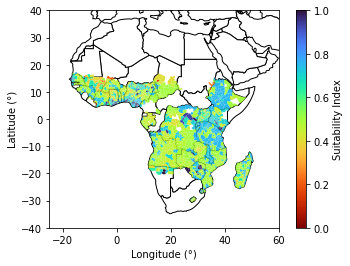

In [7]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')
df_full_suit.plot(ax=ax, column='suitability', legend=True ,cmap = 'turbo_r',vmin=0, vmax=1, legend_kwds={'label': 'Suitability Index'})
plt.xlim(-25,60) 
plt.ylim(-40,40)
plt.xlabel('Longitude (\N{degree sign})')
plt.ylabel('Latitude (\N{degree sign})')
plt.savefig(f'suitability_map.png', dpi=600)

## Plot country level suitability (can choose countries to plot)

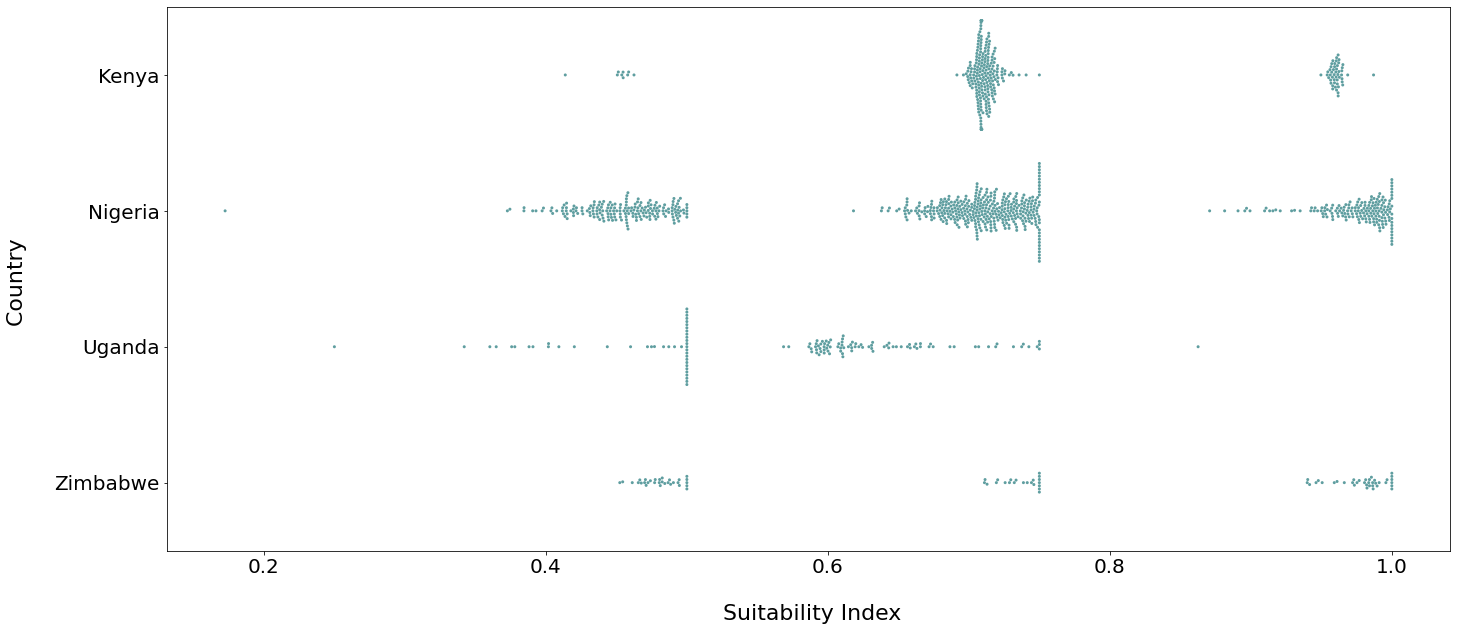

In [8]:
plt.figure(figsize=(23,10)) # may need to increase fig size depending on country distribution

# can specify countries of interest using country code
filtered_country = df_full_suit[(df_full_suit['shapeGroup'] == 'NGA') |
                                   (df_full_suit['shapeGroup'] == 'UGA')  |
                                    (df_full_suit['shapeGroup'] == 'ZWE') |
                                   (df_full_suit['shapeGroup'] == 'KEN')]

sns.swarmplot(x='suitability', y='country_name', data=filtered_country.sort_values(by="country_name"), dodge=True, size=3, color = 'cadetblue')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.ylabel('Country \n', size = 22)
plt.xlabel('\n Suitability Index', size = 22)
plt.savefig(f'country_suitability.png',bbox_inches="tight", transparent = True,
            facecolor ="w", dpi = 600)